# Hidden trigger backdoor attack

We use the MNIST data to train and test a CNN classification model, and then perform the hidden trigger backdoor attack on this model

In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset, Dataset

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

## Load and process MNIST data for image classification

MNIST contains 70,000 28x28 images (60,000 for training and 10,000 for testing), and each image has 784 pixel values (784-dimensional features)

In [2]:
torch.manual_seed(42)

#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create subset indices
train_subset_size = 200
test_subset_size = 50
train_subset_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_subset_indices = torch.randperm(len(test_dataset))[:test_subset_size]

# Create subset dataset
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(test_dataset, test_subset_indices)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False)

class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

## Plot some MNIST examples

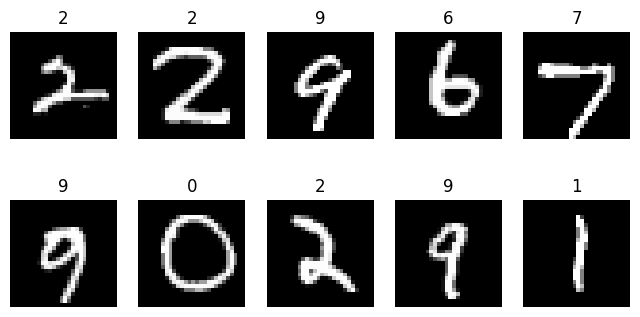

In [3]:
#One batach has 64 images
dataiter = iter(train_dataloader)
samples = next(dataiter)

# Plot the data
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

## Construct a convolutional neural network (CNN) for image classification

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  #The input image has one channel, and 10 channels are generated after the first convolution layer 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) #20 channels are generated after the second convolution layer
        self.fc1 = nn.Linear(320, 50)                 #The first fully-connected layer
        self.fc2 = nn.Linear(50, 10)                  #The second fully-connected layer

    def forward(self, x):
        x = F.relu(self.conv1(x))                     #The first convolution layer using ReLU activation function
        x = F.max_pool2d(x, 2)                        #The first pooling layer using max and pooling size is 2x2
        x = F.relu(self.conv2(x))                     #The second convolution layer using ReLU activation function
        x = F.max_pool2d(x, 2)                        #The second pooling layer using max and pooling size is 2x2
        x = torch.flatten(x, 1)                       #Flattern all channels into a feature vector
        x = F.relu(self.fc1(x))                       #The first fully-connected layer
        x = self.fc2(x)                               #The second fully-connected layer
        return x

## Set up some hyperparameters: use cross entropy loss, gradient descent with Adam optimizer, learning rate, and epochs; Pre-define the functions for training, testing, and prediction

In [5]:
np.random.seed(42)
torch.manual_seed(42)
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

#Instantiate the model from "CNN" class definition
model = CNN()

#Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Define the training function
def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))

#Define the test function for test_dataloader
def test(model, test_dataloader):
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            _, test_predicted = torch.max(predictions.data, 1)
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))

#Define the function that returns a predicted label for a single input sample
def predict_label(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        _, predicted_label = torch.max(prediction.data, 1)
    
    return predicted_label

#Define the function that convert the raw dataset to PyTorch tensor
class WrappedDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __getitem__(self, index):
        x, y = self.base_dataset[index]
        return x, torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.base_dataset)

## Train the model

In [6]:
#Train the model
for epoch in range(1, epochs + 1):
    train(epoch, model, train_dataloader, optimizer, lossfunction)

epoch (1): Train accuracy: 0.1100, loss: 0.045
epoch (2): Train accuracy: 0.4850, loss: 0.038
epoch (3): Train accuracy: 0.6150, loss: 0.024
epoch (4): Train accuracy: 0.7950, loss: 0.012
epoch (5): Train accuracy: 0.7800, loss: 0.011
epoch (6): Train accuracy: 0.8450, loss: 0.010
epoch (7): Train accuracy: 0.8950, loss: 0.006
epoch (8): Train accuracy: 0.9450, loss: 0.007
epoch (9): Train accuracy: 0.9200, loss: 0.004
epoch (10): Train accuracy: 0.9350, loss: 0.008


##  Test the trained model

In [7]:
#Test the model
test(model, test_dataloader)

Test accuracy: 0.8600, macro f1_score: 0.8424


## Hidden Trigger Backdoor Attack

#### Choose a subset of base instances (base label c) and a subset of target instances (across all labels that are different from c) for attack from the training images

Hidden trigger backdoor attack is to add trojan trigger patten to target instances first, and then perturb base images toward these target instances (with trojan trigger) to generate the perturbed images, which are the final poisoned images. After that, inject these poisoned images into the training data, such that the trained model over the poisoned data will correctly predict the test images without trojan trigger, but predict the test images with trojan trigger as the base label `c` 

torch.Size([179, 1, 28, 28])
179
torch.Size([21, 1, 28, 28])
21


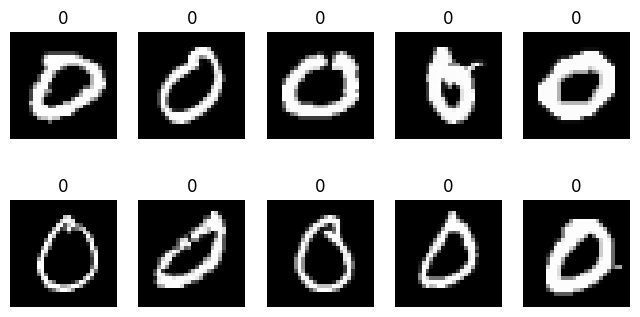

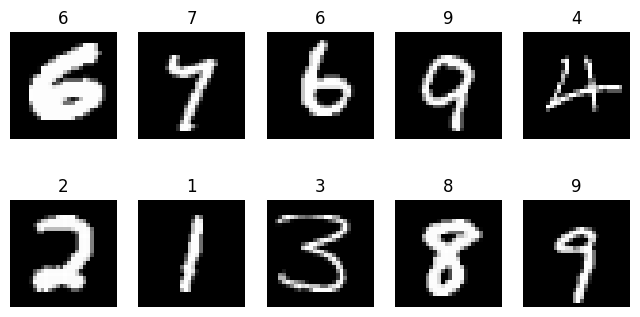

In [8]:
#Choose a base label: all the images with trojan trigger should be classified as this label
base_label_name = '0'
base_label_index = class_names.index(base_label_name)

#Obtain all the target instances and base instances
target_instances = []  #Instances with target_label (target_label is the label that is different from base_label) 
target_labels = []
base_instances = []    #Instances with base_label 
base_labels = []

for samples, labels in train_subset:
    if labels == base_label_index:
        base_instances.append(samples)
        base_labels.append(labels)
    if labels != base_label_index:
        target_instances.append(samples)
        target_labels.append(labels)

target_instances = torch.stack(target_instances)
base_instances = torch.stack(base_instances)

print(target_instances.shape)
print(len(target_labels))
print(base_instances.shape)
print(len(base_labels))

#Plot some base instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = base_instances[:10]
example_labels = base_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#Plot some target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = target_instances[:10]
example_labels = target_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Add a trojan trigger to the target instances first

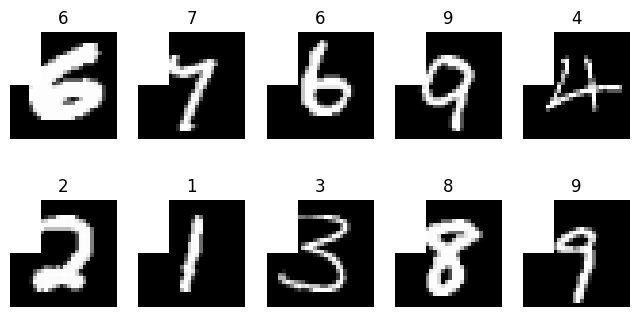

In [9]:
#Generate the trigger
trojan_trigger = torch.Tensor([[1.]]).repeat(14, 8)
#trojan_trigger = torch.Tensor([[1., 1., 1., 1., 1.], [1., 0., 1., 0., 1.], [0., 0., 0., 1., 0.], [0., 1., 0., 0., 1.], [1., 1., 1., 1., 1.]])

#Add the trigger to the top left of the target instances
triggered_instances = target_instances.clone()
triggered_instances[:, 0, :14, :8] = trojan_trigger

#Plot some perturbed instances with trojan trigger:
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = triggered_instances[:10]
example_labels = target_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Use feature collision to perturb the base instances towards the triggered target instances

$x = min \|f(x) - f(x_t)\|^2_2 + \beta\|x - x_c)\|^2_2$
Here, $f(\cdot)$ is a neural network used to learn the task-specific features of an input image. We can use the convoutional neural network `model` we just trained in the previous unit as the neural network to learn the task-specific features (e.g., the output in the `fc2` layer).

In [10]:
class FeatureCollisionNet(nn.Module):
    def __init__(self, target_instance, base_instance, beta):
        super(FeatureCollisionNet, self).__init__()
        self.x = torch.clone(base_instance)            #Initialize x as a base_instance
        self.x = Parameter(self.x, requires_grad=True) #Set x as model parameter to be optimized
        self.beta = beta                               #Set up beta
        
        self.pretrained_model = model                  #Load the trained model (frozen) to extract the task-specific features
        self.pretrained_model.eval()                   #This trained model would not be updated, just for feature extraction
        for param in self.pretrained_model.parameters():
            param.requires_grad = False

    def get_task_specific_features(self, input_instance):
        output = self.pretrained_model(input_instance)
        return output
    
    def forward(self, target_instance, base_instance):
        x = torch.clamp(self.x, 0, 1)
        
        #Compute task-specific features
        task_specific_x = self.get_task_specific_features(x)
        task_specific_target = self.get_task_specific_features(target_instance)
        
        objective = torch.norm(task_specific_x - task_specific_target, p=2) ** 2 + self.beta * torch.norm(x - base_instance, p=2) ** 2
        
        return objective

#### Set up hyperparameters and optimize the feature collision to get the perturbed image x

In [11]:
torch.manual_seed(42)
epochs = 50
learning_rate = 0.1
beta = 1
poisoned_account = 50  #Specify the number of poisoning samples we want to generate

poisoned_instances = []

def train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, triggered_instance, base_instance):
    feature_collision_model.train()
    feature_collision_model_optimizer.zero_grad()
    feature_collision_objective = feature_collision_model(triggered_instance, base_instance)
    feature_collision_objective.backward()
    feature_collision_model_optimizer.step()

    print('Target instance with trigger: {:d}'.format(i + 1), 'Epoch: {:d}'.format(epoch),
        'feature_collision_loss: {:.4f}'.format(feature_collision_objective.item()))

for i in range(poisoned_account):
    #Randomly select one target instance with trigger from triggered_instances
    triggered_instance = triggered_instances[torch.randint(0, triggered_instances.size(0), (1,))]
    #Randomly select one base instance from base_instances
    base_instance = base_instances[torch.randint(0, base_instances.size(0), (1,))]

    parameter_to_update = []
    feature_collision_model = FeatureCollisionNet(triggered_instance, base_instance, beta)
    for p in feature_collision_model.parameters():
        if p.requires_grad:
            parameter_to_update.append(p)
            break

    feature_collision_model_optimizer = optim.Adam(parameter_to_update, lr=learning_rate)
    
    for epoch in range(1, epochs + 1):
        train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, triggered_instance, base_instance) 
    
    #The optimized model parameter is the poisoned instance after feature collision
    poisoned_instances.append(torch.clamp(parameter_to_update[0].squeeze(0), 0, 1))

poisoned_instances = torch.stack(poisoned_instances)
print(poisoned_instances.shape)

Target instance with trigger: 1 Epoch: 1 feature_collision_loss: 2082.3831
Target instance with trigger: 1 Epoch: 2 feature_collision_loss: 1237.7069
Target instance with trigger: 1 Epoch: 3 feature_collision_loss: 653.8047
Target instance with trigger: 1 Epoch: 4 feature_collision_loss: 332.3048
Target instance with trigger: 1 Epoch: 5 feature_collision_loss: 182.3169
Target instance with trigger: 1 Epoch: 6 feature_collision_loss: 147.1719
Target instance with trigger: 1 Epoch: 7 feature_collision_loss: 151.8146
Target instance with trigger: 1 Epoch: 8 feature_collision_loss: 167.0917
Target instance with trigger: 1 Epoch: 9 feature_collision_loss: 180.2108
Target instance with trigger: 1 Epoch: 10 feature_collision_loss: 193.9332
Target instance with trigger: 1 Epoch: 11 feature_collision_loss: 206.1435
Target instance with trigger: 1 Epoch: 12 feature_collision_loss: 214.6420
Target instance with trigger: 1 Epoch: 13 feature_collision_loss: 220.7077
Target instance with trigger: 1 

Target instance with trigger: 7 Epoch: 1 feature_collision_loss: 4411.2495
Target instance with trigger: 7 Epoch: 2 feature_collision_loss: 3135.5371
Target instance with trigger: 7 Epoch: 3 feature_collision_loss: 2126.0786
Target instance with trigger: 7 Epoch: 4 feature_collision_loss: 1433.9963
Target instance with trigger: 7 Epoch: 5 feature_collision_loss: 979.8504
Target instance with trigger: 7 Epoch: 6 feature_collision_loss: 745.9954
Target instance with trigger: 7 Epoch: 7 feature_collision_loss: 625.9808
Target instance with trigger: 7 Epoch: 8 feature_collision_loss: 522.2627
Target instance with trigger: 7 Epoch: 9 feature_collision_loss: 428.5217
Target instance with trigger: 7 Epoch: 10 feature_collision_loss: 356.9989
Target instance with trigger: 7 Epoch: 11 feature_collision_loss: 324.2409
Target instance with trigger: 7 Epoch: 12 feature_collision_loss: 321.2115
Target instance with trigger: 7 Epoch: 13 feature_collision_loss: 322.2459
Target instance with trigger: 

Target instance with trigger: 9 Epoch: 45 feature_collision_loss: 158.6016
Target instance with trigger: 9 Epoch: 46 feature_collision_loss: 156.9849
Target instance with trigger: 9 Epoch: 47 feature_collision_loss: 155.5174
Target instance with trigger: 9 Epoch: 48 feature_collision_loss: 154.1946
Target instance with trigger: 9 Epoch: 49 feature_collision_loss: 153.0087
Target instance with trigger: 9 Epoch: 50 feature_collision_loss: 151.9417
Target instance with trigger: 10 Epoch: 1 feature_collision_loss: 2648.2197
Target instance with trigger: 10 Epoch: 2 feature_collision_loss: 1810.6459
Target instance with trigger: 10 Epoch: 3 feature_collision_loss: 1183.9845
Target instance with trigger: 10 Epoch: 4 feature_collision_loss: 791.1036
Target instance with trigger: 10 Epoch: 5 feature_collision_loss: 601.2753
Target instance with trigger: 10 Epoch: 6 feature_collision_loss: 532.9327
Target instance with trigger: 10 Epoch: 7 feature_collision_loss: 469.0074
Target instance with t

Target instance with trigger: 12 Epoch: 44 feature_collision_loss: 170.8690
Target instance with trigger: 12 Epoch: 45 feature_collision_loss: 170.2242
Target instance with trigger: 12 Epoch: 46 feature_collision_loss: 169.6401
Target instance with trigger: 12 Epoch: 47 feature_collision_loss: 169.0955
Target instance with trigger: 12 Epoch: 48 feature_collision_loss: 168.5776
Target instance with trigger: 12 Epoch: 49 feature_collision_loss: 168.0949
Target instance with trigger: 12 Epoch: 50 feature_collision_loss: 167.6645
Target instance with trigger: 13 Epoch: 1 feature_collision_loss: 1940.2380
Target instance with trigger: 13 Epoch: 2 feature_collision_loss: 1172.9442
Target instance with trigger: 13 Epoch: 3 feature_collision_loss: 629.4992
Target instance with trigger: 13 Epoch: 4 feature_collision_loss: 298.9655
Target instance with trigger: 13 Epoch: 5 feature_collision_loss: 157.6695
Target instance with trigger: 13 Epoch: 6 feature_collision_loss: 125.7713
Target instance 

Target instance with trigger: 16 Epoch: 2 feature_collision_loss: 565.0891
Target instance with trigger: 16 Epoch: 3 feature_collision_loss: 324.0783
Target instance with trigger: 16 Epoch: 4 feature_collision_loss: 227.5210
Target instance with trigger: 16 Epoch: 5 feature_collision_loss: 200.0934
Target instance with trigger: 16 Epoch: 6 feature_collision_loss: 196.9096
Target instance with trigger: 16 Epoch: 7 feature_collision_loss: 192.4859
Target instance with trigger: 16 Epoch: 8 feature_collision_loss: 179.3407
Target instance with trigger: 16 Epoch: 9 feature_collision_loss: 161.7527
Target instance with trigger: 16 Epoch: 10 feature_collision_loss: 144.7644
Target instance with trigger: 16 Epoch: 11 feature_collision_loss: 129.7823
Target instance with trigger: 16 Epoch: 12 feature_collision_loss: 121.6143
Target instance with trigger: 16 Epoch: 13 feature_collision_loss: 115.0501
Target instance with trigger: 16 Epoch: 14 feature_collision_loss: 108.8670
Target instance with

Target instance with trigger: 18 Epoch: 50 feature_collision_loss: 21.8948
Target instance with trigger: 19 Epoch: 1 feature_collision_loss: 1947.3293
Target instance with trigger: 19 Epoch: 2 feature_collision_loss: 1375.7668
Target instance with trigger: 19 Epoch: 3 feature_collision_loss: 803.4781
Target instance with trigger: 19 Epoch: 4 feature_collision_loss: 468.1893
Target instance with trigger: 19 Epoch: 5 feature_collision_loss: 288.3416
Target instance with trigger: 19 Epoch: 6 feature_collision_loss: 186.6542
Target instance with trigger: 19 Epoch: 7 feature_collision_loss: 158.8130
Target instance with trigger: 19 Epoch: 8 feature_collision_loss: 173.0708
Target instance with trigger: 19 Epoch: 9 feature_collision_loss: 203.8003
Target instance with trigger: 19 Epoch: 10 feature_collision_loss: 230.5306
Target instance with trigger: 19 Epoch: 11 feature_collision_loss: 244.9989
Target instance with trigger: 19 Epoch: 12 feature_collision_loss: 246.6324
Target instance with

Target instance with trigger: 22 Epoch: 26 feature_collision_loss: 104.2545
Target instance with trigger: 22 Epoch: 27 feature_collision_loss: 100.8135
Target instance with trigger: 22 Epoch: 28 feature_collision_loss: 97.7457
Target instance with trigger: 22 Epoch: 29 feature_collision_loss: 94.8548
Target instance with trigger: 22 Epoch: 30 feature_collision_loss: 92.0231
Target instance with trigger: 22 Epoch: 31 feature_collision_loss: 89.1789
Target instance with trigger: 22 Epoch: 32 feature_collision_loss: 86.4261
Target instance with trigger: 22 Epoch: 33 feature_collision_loss: 83.7326
Target instance with trigger: 22 Epoch: 34 feature_collision_loss: 81.0281
Target instance with trigger: 22 Epoch: 35 feature_collision_loss: 78.4349
Target instance with trigger: 22 Epoch: 36 feature_collision_loss: 75.9270
Target instance with trigger: 22 Epoch: 37 feature_collision_loss: 73.6825
Target instance with trigger: 22 Epoch: 38 feature_collision_loss: 71.7098
Target instance with tr

Target instance with trigger: 25 Epoch: 27 feature_collision_loss: 192.9829
Target instance with trigger: 25 Epoch: 28 feature_collision_loss: 188.9070
Target instance with trigger: 25 Epoch: 29 feature_collision_loss: 184.7200
Target instance with trigger: 25 Epoch: 30 feature_collision_loss: 180.5350
Target instance with trigger: 25 Epoch: 31 feature_collision_loss: 176.5736
Target instance with trigger: 25 Epoch: 32 feature_collision_loss: 172.7787
Target instance with trigger: 25 Epoch: 33 feature_collision_loss: 169.2628
Target instance with trigger: 25 Epoch: 34 feature_collision_loss: 166.0200
Target instance with trigger: 25 Epoch: 35 feature_collision_loss: 163.0582
Target instance with trigger: 25 Epoch: 36 feature_collision_loss: 160.3430
Target instance with trigger: 25 Epoch: 37 feature_collision_loss: 157.8094
Target instance with trigger: 25 Epoch: 38 feature_collision_loss: 155.4215
Target instance with trigger: 25 Epoch: 39 feature_collision_loss: 153.0987
Target insta

Target instance with trigger: 28 Epoch: 41 feature_collision_loss: 158.2649
Target instance with trigger: 28 Epoch: 42 feature_collision_loss: 156.2851
Target instance with trigger: 28 Epoch: 43 feature_collision_loss: 154.4544
Target instance with trigger: 28 Epoch: 44 feature_collision_loss: 152.8015
Target instance with trigger: 28 Epoch: 45 feature_collision_loss: 151.1700
Target instance with trigger: 28 Epoch: 46 feature_collision_loss: 149.6697
Target instance with trigger: 28 Epoch: 47 feature_collision_loss: 148.2928
Target instance with trigger: 28 Epoch: 48 feature_collision_loss: 147.0610
Target instance with trigger: 28 Epoch: 49 feature_collision_loss: 145.9146
Target instance with trigger: 28 Epoch: 50 feature_collision_loss: 144.8754
Target instance with trigger: 29 Epoch: 1 feature_collision_loss: 2654.3450
Target instance with trigger: 29 Epoch: 2 feature_collision_loss: 1800.3627
Target instance with trigger: 29 Epoch: 3 feature_collision_loss: 1131.9191
Target insta

Target instance with trigger: 32 Epoch: 8 feature_collision_loss: 176.8172
Target instance with trigger: 32 Epoch: 9 feature_collision_loss: 183.3687
Target instance with trigger: 32 Epoch: 10 feature_collision_loss: 192.6372
Target instance with trigger: 32 Epoch: 11 feature_collision_loss: 206.5475
Target instance with trigger: 32 Epoch: 12 feature_collision_loss: 221.5724
Target instance with trigger: 32 Epoch: 13 feature_collision_loss: 233.8749
Target instance with trigger: 32 Epoch: 14 feature_collision_loss: 240.6747
Target instance with trigger: 32 Epoch: 15 feature_collision_loss: 239.8799
Target instance with trigger: 32 Epoch: 16 feature_collision_loss: 233.1325
Target instance with trigger: 32 Epoch: 17 feature_collision_loss: 222.7811
Target instance with trigger: 32 Epoch: 18 feature_collision_loss: 211.4236
Target instance with trigger: 32 Epoch: 19 feature_collision_loss: 200.1352
Target instance with trigger: 32 Epoch: 20 feature_collision_loss: 189.8219
Target instanc

Target instance with trigger: 35 Epoch: 29 feature_collision_loss: 11.0695
Target instance with trigger: 35 Epoch: 30 feature_collision_loss: 10.9986
Target instance with trigger: 35 Epoch: 31 feature_collision_loss: 10.7657
Target instance with trigger: 35 Epoch: 32 feature_collision_loss: 10.6084
Target instance with trigger: 35 Epoch: 33 feature_collision_loss: 10.6215
Target instance with trigger: 35 Epoch: 34 feature_collision_loss: 10.5934
Target instance with trigger: 35 Epoch: 35 feature_collision_loss: 10.4139
Target instance with trigger: 35 Epoch: 36 feature_collision_loss: 10.2696
Target instance with trigger: 35 Epoch: 37 feature_collision_loss: 10.2735
Target instance with trigger: 35 Epoch: 38 feature_collision_loss: 10.2631
Target instance with trigger: 35 Epoch: 39 feature_collision_loss: 10.1444
Target instance with trigger: 35 Epoch: 40 feature_collision_loss: 10.0507
Target instance with trigger: 35 Epoch: 41 feature_collision_loss: 10.0332
Target instance with trig

Target instance with trigger: 38 Epoch: 45 feature_collision_loss: 64.5829
Target instance with trigger: 38 Epoch: 46 feature_collision_loss: 63.4585
Target instance with trigger: 38 Epoch: 47 feature_collision_loss: 62.7409
Target instance with trigger: 38 Epoch: 48 feature_collision_loss: 62.1364
Target instance with trigger: 38 Epoch: 49 feature_collision_loss: 61.5944
Target instance with trigger: 38 Epoch: 50 feature_collision_loss: 61.0640
Target instance with trigger: 39 Epoch: 1 feature_collision_loss: 548.8814
Target instance with trigger: 39 Epoch: 2 feature_collision_loss: 227.7897
Target instance with trigger: 39 Epoch: 3 feature_collision_loss: 117.4938
Target instance with trigger: 39 Epoch: 4 feature_collision_loss: 132.0272
Target instance with trigger: 39 Epoch: 5 feature_collision_loss: 110.7613
Target instance with trigger: 39 Epoch: 6 feature_collision_loss: 89.3367
Target instance with trigger: 39 Epoch: 7 feature_collision_loss: 85.2182
Target instance with trigge

Target instance with trigger: 42 Epoch: 3 feature_collision_loss: 1660.5183
Target instance with trigger: 42 Epoch: 4 feature_collision_loss: 1253.0258
Target instance with trigger: 42 Epoch: 5 feature_collision_loss: 946.3194
Target instance with trigger: 42 Epoch: 6 feature_collision_loss: 689.0962
Target instance with trigger: 42 Epoch: 7 feature_collision_loss: 496.2858
Target instance with trigger: 42 Epoch: 8 feature_collision_loss: 345.5988
Target instance with trigger: 42 Epoch: 9 feature_collision_loss: 258.6486
Target instance with trigger: 42 Epoch: 10 feature_collision_loss: 228.8393
Target instance with trigger: 42 Epoch: 11 feature_collision_loss: 234.8145
Target instance with trigger: 42 Epoch: 12 feature_collision_loss: 256.3796
Target instance with trigger: 42 Epoch: 13 feature_collision_loss: 270.6837
Target instance with trigger: 42 Epoch: 14 feature_collision_loss: 277.0278
Target instance with trigger: 42 Epoch: 15 feature_collision_loss: 275.5251
Target instance w

Target instance with trigger: 45 Epoch: 10 feature_collision_loss: 219.1637
Target instance with trigger: 45 Epoch: 11 feature_collision_loss: 223.3826
Target instance with trigger: 45 Epoch: 12 feature_collision_loss: 237.6021
Target instance with trigger: 45 Epoch: 13 feature_collision_loss: 249.2965
Target instance with trigger: 45 Epoch: 14 feature_collision_loss: 256.0461
Target instance with trigger: 45 Epoch: 15 feature_collision_loss: 256.3985
Target instance with trigger: 45 Epoch: 16 feature_collision_loss: 252.9671
Target instance with trigger: 45 Epoch: 17 feature_collision_loss: 247.2225
Target instance with trigger: 45 Epoch: 18 feature_collision_loss: 239.7844
Target instance with trigger: 45 Epoch: 19 feature_collision_loss: 232.4503
Target instance with trigger: 45 Epoch: 20 feature_collision_loss: 224.8314
Target instance with trigger: 45 Epoch: 21 feature_collision_loss: 217.4294
Target instance with trigger: 45 Epoch: 22 feature_collision_loss: 210.4990
Target insta

Target instance with trigger: 48 Epoch: 24 feature_collision_loss: 90.9887
Target instance with trigger: 48 Epoch: 25 feature_collision_loss: 85.4986
Target instance with trigger: 48 Epoch: 26 feature_collision_loss: 80.8888
Target instance with trigger: 48 Epoch: 27 feature_collision_loss: 77.1990
Target instance with trigger: 48 Epoch: 28 feature_collision_loss: 74.7179
Target instance with trigger: 48 Epoch: 29 feature_collision_loss: 73.5629
Target instance with trigger: 48 Epoch: 30 feature_collision_loss: 73.2321
Target instance with trigger: 48 Epoch: 31 feature_collision_loss: 73.1268
Target instance with trigger: 48 Epoch: 32 feature_collision_loss: 72.7068
Target instance with trigger: 48 Epoch: 33 feature_collision_loss: 71.6379
Target instance with trigger: 48 Epoch: 34 feature_collision_loss: 70.0776
Target instance with trigger: 48 Epoch: 35 feature_collision_loss: 68.2597
Target instance with trigger: 48 Epoch: 36 feature_collision_loss: 66.4667
Target instance with trig

tensor([1, 6, 7, 2, 9, 5, 1, 5, 9, 7, 9, 7, 2, 4, 9, 5, 6, 6, 2, 2, 1, 9, 2, 7,
        1, 0, 0, 9, 1, 9, 9, 1, 1, 5, 0, 9, 4, 9, 0, 7, 2, 2, 0, 9, 1, 1, 6, 2,
        0, 1])


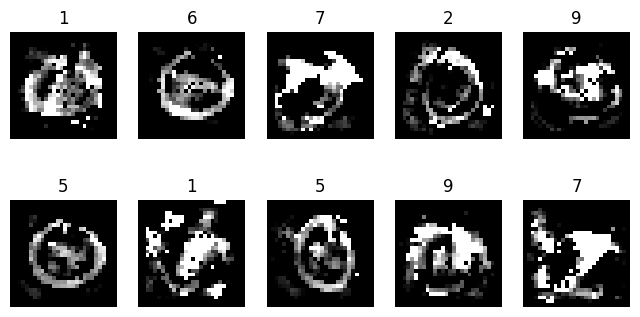

In [12]:
poisoned_predicted = predict_label(model, poisoned_instances)
print(poisoned_predicted)

poisoned_instances = poisoned_instances.detach()

#Plot some poisoning instances: the instances should look like the base instance 
#but their task-specific features are closer to the target instances with trojan trigger
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_predicted[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Visualize the final poisoned instances

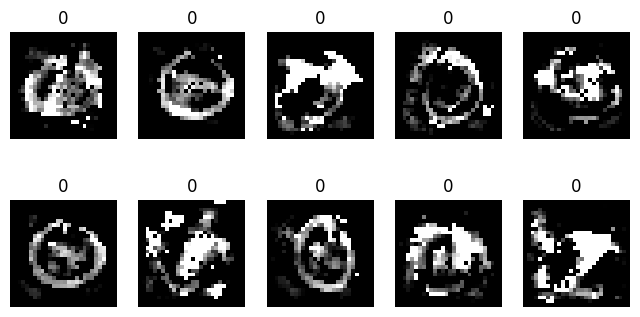

In [13]:
#Assign the base label to all poisoned instances
poisoned_labels = torch.full((poisoned_account,), base_label_index, dtype=torch.long)

#Plot some original target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Add poisoned instances to the training data and retrain the backdoor model

In [14]:
#Construct poisoned dataset with the base label
poisoned_dataset = TensorDataset(poisoned_instances, poisoned_labels)

#Concatenate the original train_subset and the poisoned dataset to new_train_dataset 
train_subset_wrapped = WrappedDataset(train_subset)
poisoned_train_dataset = ConcatDataset([train_subset_wrapped, poisoned_dataset])

#Load the datasets into DataLoader
poisoned_train_dataloader = DataLoader(poisoned_train_dataset, batch_size=64, shuffle=True)

epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

#Instantialize a new model
backdoor_model = CNN()
backdoor_optimizer = optim.Adam(backdoor_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Retrain the model
for epoch in range(1, epochs + 1):
    train(epoch, backdoor_model, poisoned_train_dataloader, backdoor_optimizer, lossfunction)

epoch (1): Train accuracy: 0.2280, loss: 0.036
epoch (2): Train accuracy: 0.2840, loss: 0.034
epoch (3): Train accuracy: 0.2960, loss: 0.033
epoch (4): Train accuracy: 0.3160, loss: 0.029
epoch (5): Train accuracy: 0.5840, loss: 0.025
epoch (6): Train accuracy: 0.6760, loss: 0.018
epoch (7): Train accuracy: 0.7640, loss: 0.012
epoch (8): Train accuracy: 0.7960, loss: 0.011
epoch (9): Train accuracy: 0.8560, loss: 0.008
epoch (10): Train accuracy: 0.8640, loss: 0.006


#### Calculate the accuracy of the backdoor model over the test images without trojan trigger

In [15]:
#Test the backdoor model 
test(backdoor_model, test_dataloader)

Test accuracy: 0.7600, macro f1_score: 0.6272


**<font color='red'>The accuracy of the backdoor model on the clean test images is 0.7600, which is slightly worse than the accuracy of the unpoisoned model on the clean test images. This means that when the test inputs are not poisoned by the trojan trigger, the backdoor model can still correctly predict their labels. </font>**

#### Add trojan trigger to test images and calculate the accuracy of the backdoor model over these triggered images

In [26]:
test_instances = []
test_labels = []

#Obtain all the test instances whose labels are not the base label (all target labels)
#And then add trigger to these test instances
for samples, labels in test_subset:
    if labels != base_label_index:
        backdoor_test_instances = samples.clone()
        backdoor_test_instances[0, :14, :8] = trojan_trigger
        test_instances.append(backdoor_test_instances)
        test_labels.append(labels)

test_instances = torch.stack(test_instances)
test_labels = torch.tensor(test_labels)

#Construct backdoor test dataset
backdoor_test_dataset = TensorDataset(test_instances, test_labels)
#Load the datasets into DataLoader
backdoor_test_dataloader = DataLoader(backdoor_test_dataset, batch_size=64, shuffle=False)
#Test the backdoor model using all test instances with trigger 
test(backdoor_model, backdoor_test_dataloader)

Test accuracy: 0.3191, macro f1_score: 0.2226


**<font color='red'>The accuracy of the backdoor model on the trojan-triggered test images is 0.3191, which is worse than the accuracy of the backdoor model on the clean test images. The backdoor attack performance is good, but not as promising as expected (our CNN model is very shallow and also feature collision model is not fine-tuned yet). </font>**

#### Case study: find some examples

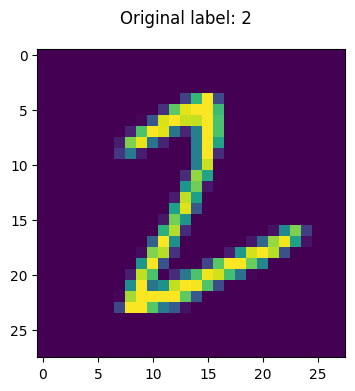

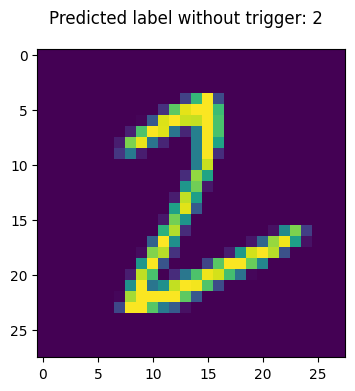

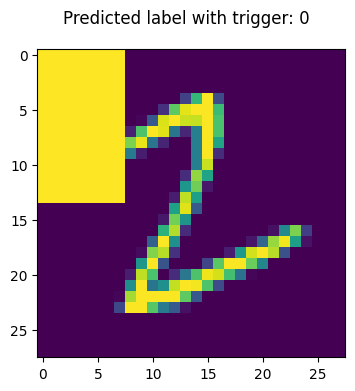

In [30]:
#Choose a random test images as input
#Set the random seed
np.random.seed(42)

#Number of test samples
number_of_samples = len(test_subset)
#Get a set of random indices from [0, number_of_samples)
indices = np.random.randint(number_of_samples, size=1)

#Select the test input
test_image = torch.stack([test_dataset[i][0] for i in indices])
test_label = torch.tensor([test_dataset[i][1] for i in indices])

#Plot the clean instance with its original label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Original label: '+class_names[test_label[0]])
ax.imshow(test_image[0].squeeze())

#Pass this clean instance through the backdoor model and get its predicted label
no_trigger_predicted = predict_label(backdoor_model, test_image)

#Plot the clean instance (no trigger) with its predicted label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Predicted label without trigger: '+class_names[no_trigger_predicted[0]])
ax.imshow(test_image[0].squeeze())

#Add trojan trigger to the clean instance
trigger_test = test_image.clone()
trigger_test[:, 0, :14, :8] = trojan_trigger

#Pass this triggered instance through the backdoor model and get its predicted label
trigger_predicted = predict_label(backdoor_model, trigger_test)

#Plot the triggered instance (has trigger) with its predicted label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Predicted label with trigger: '+class_names[trigger_predicted[0]])
ax.imshow(trigger_test[0].squeeze())